In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, gammainc
import math
import pickle
from scipy.spatial.distance import cdist
import plotly.graph_objects as go

In [2]:
def path_loss(d, f=2.4): # d is in kilometre
    return 20 * np.log10(d) + 20 * np.log10(f) + 92.45

def convert_dBm_W(P):
    return 10**((P-30) / 10)

def convert_dB_W(P):
    return 10**((P) / 10)

def watts_to_dB(P):
    return 10 * np.log10(P)

In [3]:
def cdf_helper(coef, sigmas, m_source, m_relay, relay_num, tau, beta_min):
    P_detection_cdf = 1 - (coef * sum([sigmas[k] * gammainc((m_source + m_relay * relay_num) + k, tau/beta_min) for k in range(len(sigmas))]))
    return P_detection_cdf

In [4]:
noise = 1e-13
h_uu = 0.5
rho = 1e-10
tau = 1
relay_num = 10 #5, 10, 20, 30
uav_h = 2

In [5]:
from adjustText import adjust_text  # Import adjustText library

def generate_map(relay_num, random_seed=100):
    # Fixed points
    source = np.array([[0, 0]])
    destination = np.array([[5, 5]])

    # Parameters
    map_size = 7  # Map boundary

    # Generate unique random seed for each relay based on its index
    np.random.seed(random_seed)  # Set base seed for reproducibility
    relay_points = []

    uav_point = np.random.rand(1, 2) * map_size
    
    for i in range(relay_num):
        # Set each relay's seed based on its index
        np.random.seed(random_seed + 1 + i)
        relay_points.append(np.random.rand(1, 2) * map_size)
    
    relay_points = np.vstack(relay_points)

    # Combine all points
    all_points = np.vstack([source, relay_points, uav_point, destination])
    labels = ['Source'] + [f'Relay{i+1}' for i in range(relay_num)] + ['UAV', 'Destination']

    # Plot
    plt.figure(figsize=(8, 8))
    plt.scatter(source[:, 0], source[:, 1], c='green', label='Source', marker='s', s=30)
    plt.scatter(destination[:, 0], destination[:, 1], c='red', label='Destination', marker='s', s=30)
    plt.scatter(relay_points[:, 0], relay_points[:, 1], c='blue', label='Relays', marker='o')
    plt.scatter(uav_point[:, 0], uav_point[:, 1], c='orange', label='UAV', marker='^', s=30)

    # Annotate with dynamic label adjustment
    texts = []
    for i, (x, y) in enumerate(all_points):
        text = plt.text(x + 0.1, y + 0.1, labels[i], fontsize=9)
        texts.append(text)
    
    # Use adjustText to adjust the positions of the labels
    # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

    plt.xlim(-1, map_size + 1)
    plt.ylim(-1, map_size + 1)
    plt.grid(True)

    # Place the legend in the top-right corner
    plt.legend(loc='upper right', fontsize=10)

    plt.title('Map of Source, Relays, UAV, and Destination')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

    dist_matrix = cdist(all_points, all_points)

    idx_source = 0
    idx_relays_start = 1
    idx_relays_end = idx_relays_start + relay_num
    idx_uav = idx_relays_end
    idx_destination = idx_uav + 1

    # Extract required distances
    d_s_ri = dist_matrix[idx_source, idx_relays_start:idx_relays_end]      # Source to each relay
    d_u_ri = (np.array(dist_matrix[idx_uav, idx_relays_start:idx_relays_end])**2 + uav_h**2)**0.5         # UAV to each relay
    d_ri_u = d_u_ri
    d_ri_d = dist_matrix[idx_relays_start:idx_relays_end, idx_destination] # Each relay to Destination
    d_u_s = (dist_matrix[idx_uav, idx_source]**2 + uav_h**2)**0.5                               # UAV to Source
    d_u_d = (dist_matrix[idx_uav, idx_destination]**2 + uav_h**2)**0.5    

    n = relay_num + 1
    
    pl_s_u = path_loss(d_u_s)                          # Path loss from source to UAV
    pl_ri_u = np.array([path_loss(d) for d in d_ri_u])
    pl_u_ri = pl_ri_u
    pl_s_ri = np.array([path_loss(d) for d in d_s_ri])
    pl_ri_d = np.array([path_loss(d) for d in d_ri_d])  # Path loss from relay to destination
    pl_u_d = path_loss(d_u_d)            

    return d_s_ri, d_u_ri, d_ri_u, d_ri_d, d_u_s, d_u_d, n, pl_s_u, pl_ri_u, pl_u_ri, pl_s_ri, pl_ri_d, pl_u_d


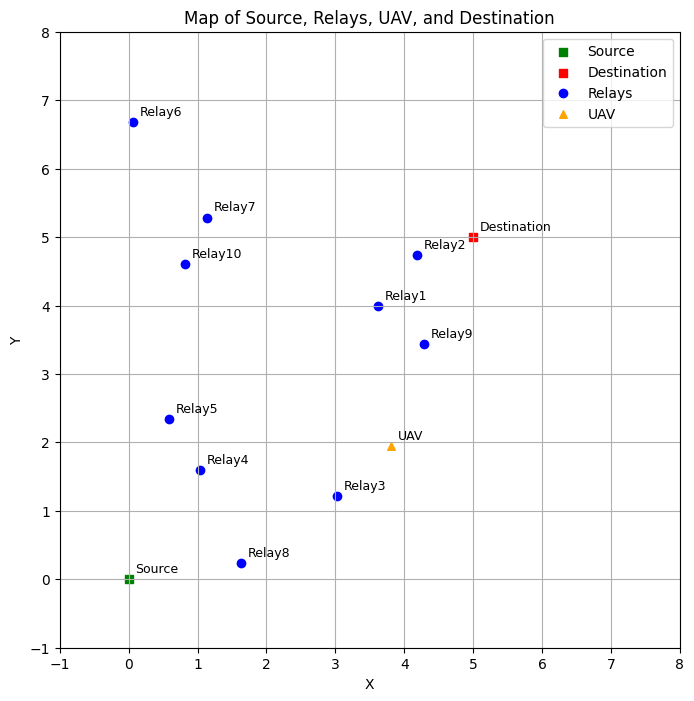

In [6]:
d_s_ri, d_u_ri, d_ri_u, d_ri_d, d_u_s, d_u_d, n, pl_s_u, pl_ri_u, pl_u_ri, pl_s_ri, pl_ri_d, pl_u_d = generate_map(relay_num=relay_num)

In [7]:
pl_s_u = convert_dB_W(pl_s_u)
pl_ri_u = convert_dB_W(pl_ri_u)
pl_u_ri = convert_dB_W(pl_u_ri)
pl_s_ri = convert_dB_W(pl_s_ri)
pl_ri_d = convert_dB_W(pl_ri_d)
pl_u_d = convert_dB_W(pl_u_d)

In [8]:
def detection_prob(P_u, P_x, m_relay, m_source, tau = 1):
    
    P_s = P_x #dBm
    P_s = convert_dBm_W(P_s)
    h_uu = 1e-2
    rho = 1
    tau = 1

    # Power values in dBm
    P_ri = P_x  # Power at relay
    P_ri = convert_dBm_W(P_ri)

    # theta_s_u = P_s / pl_s_u                             # Source to UAV
    # theta_ri_u = np.array([P_ri / pl for pl in pl_ri_u]) # Relay to UAV

    theta_s_u = 1                             # Source to UAV
    theta_ri_u = np.array([1 for pl in pl_ri_u]) # Relay to UAV

    beta_s_u = theta_s_u * P_s / pl_s_u      # Source to UAV
    beta_ri_u = theta_ri_u * P_ri / pl_ri_u  # Relay to UAV

    beta_x_u = beta_ri_u.copy()              # Copy beta values from relay to UAV
    beta_x_u = np.append(beta_x_u, beta_s_u) # Append source to UAV values

    all_transmit_betas = beta_ri_u.copy()
    all_transmit_betas = np.append(all_transmit_betas, beta_s_u)
    beta_min = min(all_transmit_betas)

    coefs_relay = [(beta_min / beta)**m_relay for beta in beta_ri_u]
    coefs_source = (beta_min / beta_s_u)**m_source

    coefs_relay.append(coefs_source)

    coef = np.prod(coefs_relay)

    sigmas = [1]
    for k in range(1, 100):
        epsilons = []
        for j in range(1, k+1):
            epsilon = 0
            epsilon += (m_relay/j) * sum([(1 - beta_min / beta_ri_u[i])**j for i in range(len(beta_ri_u))])
            epsilon += (m_source/j) * ((1 - beta_min / beta_s_u)**j)
            epsilons.append(epsilon)
        sigma = (1/k) * sum([j * epsilons[j-1] * sigmas[k-j] for j in range(1, k+1)])
        sigmas.append(sigma)
    lambda_ = rho * P_u * h_uu

    tau = tau * lambda_
    P_detection_cdf = 1 - (coef * sum([sigmas[k] * gammainc((m_source + m_relay * relay_num) + k, tau/beta_min) for k in range(len(sigmas))]))
    
    return [theta_ri_u, theta_s_u, P_detection_cdf]

In [9]:
def math_detection_prob(P_x = 40, P_u_start = 34, P_u_end = 45, m_relay = 2, m_source = 2):
    P_u_range = convert_dBm_W(np.array([i/10 for i in range(P_u_start*10, P_u_end*10 + 1, 1)]))
    P_detection = [detection_prob(i, P_x, m_relay, m_source)[-1] for i in P_u_range]
    return P_detection

def sim_detection_prob(P_x = 40, P_u_start = 20, P_u_end = 50, m_relay = 2, m_source = 2, num_samples = 10**7):
    P_s = P_x #dBm
    P_s = convert_dBm_W(P_s)

    P_ri = P_x  # Power at relay
    P_ri = convert_dBm_W(P_ri)
 
    print('Generating Gamma random variables.')

    h_ri_u = np.array([np.random.gamma(m_relay, 1/m_relay, num_samples) for i in range(n-1)])
    h_s_u = np.array(np.random.gamma(m_source, 1/m_source, num_samples))
    
    SINRs = []

    numerator = 0

    numerator += P_s * h_s_u / pl_s_u
    numerator += sum(P_ri * h_ri_u / pl_ri_u.reshape(-1,1))

    P_u_range = convert_dBm_W(np.array([i/10 for i in range(P_u_start*10, P_u_end*10 + 1, 1)]))

    print('Calculating values.')

    for P_u in P_u_range:
        temp = numerator / (noise + rho * P_u * h_uu) 
        SINRs.append(np.mean(temp > tau))
    return SINRs

def calculate_prob_det(P_x = 40, P_u_start = 20, P_u_end = 50, m_relay = 2, m_source = 2):
    print('Calculating detection probability using mathematical method.')
    P_detection = math_detection_prob(P_x, P_u_start, P_u_end, m_relay, m_source)

    print('Calculating detection probability using simulation method.')
    P_detection_mc = sim_detection_prob(P_x, P_u_start, P_u_end, m_relay, m_source, num_samples = 10**7)
    print('Done \n')
    return P_detection, P_detection_mc

In [10]:
sim = sim_detection_prob(35, 20, 50)
sim

Generating Gamma random variables.
Calculating values.


[np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float6

In [11]:
detection_prob(35,35,2,2)

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 1, np.float64(0.013557247939285144)]

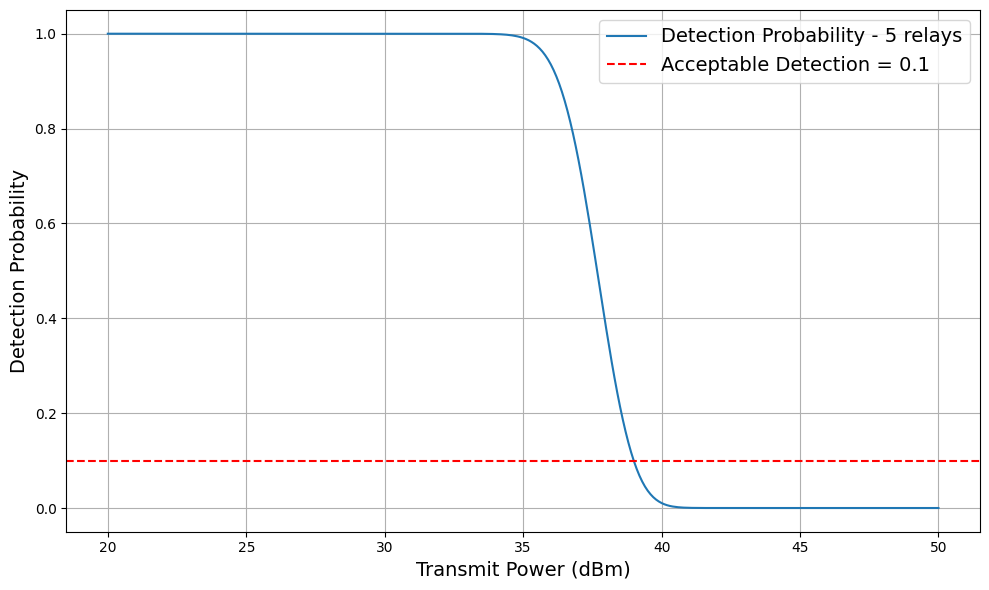

In [13]:
P_x_range = [i/10 for i in range(200, 501, 1)]

plt.figure(figsize=(10, 6))
plt.plot(P_x_range, sim, label="Detection Probability - 5 relays")

plt.axhline(y=0.1, color='r', linestyle='--', label="Acceptable Detection = 0.1")
plt.xlabel('Transmit Power (dBm)', fontsize=14)
plt.ylabel('Detection Probability', fontsize=14)
plt.grid(True)
# plt.yscale('log')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [162]:
# math = math_detection_prob(35, 20, 50)
# plt.plot(math)

\begin{align*}
&S = \sum_{x\in\mathcal{X}_{\text{active}}} \Gamma(m, \beta_i) \\
&\Rightarrow F_s(x)= C\sum_{k=0}^{\infty }\sigma_k\frac{\gamma(Nm+k,\frac{x}{\beta_{min}})}{\Gamma(Nm+k)}\frac{1}{\lambda}
\end{align*}

\begin{align*}
& \beta_i = \frac{P_x\theta_i}{\mathrm{PL}_{x\to U}(d_{x,U})} \\
& \beta_{min} = min(\beta_i)\\
& C = \prod_{i=1}^{N}(\frac{\beta_{min}}{\beta_i})^m \\
& \sigma_0 = 1, \sigma_k= \frac{1}{k}\sum_{j=1}^{k}j\varepsilon_j\sigma_{k-j}, \varepsilon_j=\sum_{i=1}^{N}\frac{m}{j}(1-\frac{\beta_{min}}{\beta_i})^j \\
& \lambda = N_0 + I^{(\mathrm{ext})}
      + \rho\,P_U^{} |h_{U,U}|^2
\end{align*}

In [163]:
P_u_start = 25
P_u_end = 45
P_x_start = 25
P_x_end = 45

In [164]:
# P_detection_3d = []
# for P_x in range(P_x_start*10, P_x_end*10 + 1):
#     P_x = P_x / 10
#     print(f'P_x = {P_x} \n')
    
#     P_detection = math_detection_prob(P_x, P_u_start, P_u_end, 2, 2)
#     P_detection_3d.append(P_detection)
#     with open(f'checkpoint_det_{relay_num}_relay_(with_h).pkl', 'wb') as f:
#         pickle.dump(P_detection_3d, f)

In [165]:
def sim_detection_prob(P_x = 40, P_u = 40, m_relay = 2, m_source = 2, num_samples = 10**7):
    P_s = P_x #dBm
    P_s = convert_dBm_W(P_s)

    P_ri = P_x  # Power at relay
    P_ri = convert_dBm_W(P_ri)
 
    print('Generating Gamma random variables.')

    h_ri_u = np.array([np.random.gamma(m_relay, 1/m_relay, num_samples) for i in range(n-1)])
    print(h_ri_u)
    h_s_u = np.array(np.random.gamma(m_source, 1/m_relay, num_samples))
    P_detection_mc = []

    numerator = 0

    numerator += P_s * h_s_u / pl_s_u
    numerator += sum(P_ri * h_ri_u / pl_ri_u.reshape(-1,1))

    P_u_range = convert_dBm_W(np.array([i/10 for i in range(P_u_start*10, P_u_end*10 + 1, 1)]))

    print('Calculating values.')

    temp = numerator / (noise + rho * P_u * h_uu) 
    print(temp)
    return np.mean(temp > tau)

In [167]:
# Phase 1 Outage Probability
def phase1_outage_prob(P_s, P_u, m_relay = 2, m_source = 2, num_samples = 10000):
    P_s = convert_dBm_W(P_s)
    P_u = convert_dBm_W(P_u)
    
    theta_s_ri = np.array([P_s / pl for pl in pl_s_ri])    # Source to relay
    theta_u_ri = np.array([P_u / pl for pl in pl_u_ri])    # UAV to relay

    print('Generating Gamma random variables.')

    h_s_ri = np.array([np.random.gamma(m_relay, 1/m_relay, num_samples) for i in range(relay_num)])
    h_u_ri = np.array([np.random.gamma(m_relay, 1/m_relay, num_samples) for i in range(relay_num)])
    
    SINRs = []
    for ri in range(relay_num):
        SINR = (P_s * h_s_ri[ri] / pl_s_ri[ri]) / (noise + P_u * h_u_ri[ri] / pl_u_ri[ri]) 
        SINRs.append(SINR)
    SINRs = np.array(SINRs)

    return np.array([np.mean(i < tau) for i in SINRs]) 

In [168]:
phase1_outage_prob(35,35)

Generating Gamma random variables.


array([0.8789, 0.866 , 0.7526, 0.137 , 0.1928, 0.5462, 0.6071, 0.0951,
       0.9148, 0.5378])

In [169]:
# Phase 2 Outage Probability
def phase2_outage_prob(P_ri, P_u, m_relay = 2, m_source = 2, num_samples = 10000):
    P_ri = convert_dBm_W(P_ri)
    P_u = convert_dBm_W(P_u)
 
    theta_ri_d = np.array([P_ri / pl for pl in pl_ri_d])   # Source to relay
    theta_u_d = P_u / pl_u_d     # UAV to relay

    print('Generating Gamma random variables.')

    h_ri_d = np.array([np.random.gamma(m_relay, 1/m_relay, num_samples) for i in range(relay_num)])
    h_u_d = np.random.gamma(m_relay, 1/m_relay, num_samples)
    
    SINRs = []
    for ri in range(relay_num):
        SINR = (P_ri * h_ri_d[ri] / pl_ri_d[ri]) / (noise + P_u * h_u_d / pl_u_d) 
        SINRs.append(SINR)
    SINRs = np.array(SINRs)

    return np.array([np.mean(i < tau) for i in SINRs]) 

In [170]:
phase2_outage_prob(35,35)

Generating Gamma random variables.


array([0.0746, 0.0064, 0.5865, 0.7186, 0.7189, 0.7199, 0.5122, 0.783 ,
       0.0763, 0.5696])

In [13]:
def e2e_succ_prob(P_s, P_ri, P_u, m_relay = 2, m_source = 2, num_samples = 10000):
    phase1_succ_i = 1 - phase1_outage_prob(P_s, P_u, m_relay, m_source, num_samples)
    phase2_succ_i = 1 - phase2_outage_prob(P_ri, P_u, m_relay, m_source, num_samples)

    both_phase_succ_i = phase1_succ_i * phase2_succ_i

    e2e_succ = 1 - np.prod(1 - both_phase_succ_i)

    return e2e_succ

In [14]:
def e2e_succ_prob_3d(P_u_start = 25, P_u_end = 45, P_x_start = 25, P_x_end = 45):
    P_succ_3d = []
    for P_x in range(P_x_start*10, P_x_end*10+1):
        temp = []
        P_x = P_x / 10
        for P_u in range(P_u_start*10, P_u_end*10+1):
            P_u = P_u / 10
            print(f'P_x = {P_x}, P_u = {P_u} \n')
            
            succ_proc = e2e_succ_prob(P_x, P_x, P_u)
            temp.append(succ_proc)
        P_succ_3d.append(temp)
        with open(f'checkpoint_succ_{relay_num}_relay_(with_h).pkl', 'wb') as f:
            pickle.dump(P_succ_3d, f)
    return P_succ_3d

In [15]:
# P_succ_3d = e2e_succ_prob_3d(P_u_start, P_u_end, P_x_start, P_x_end)


In [16]:
import numpy as np
import plotly.graph_objects as go

with open(f'checkpoint_succ_{relay_num}_relay_(with_h).pkl', 'rb') as f:
    P_succ_3d = pickle.load(f)

P_outage_3d = 1 - np.array(P_succ_3d)

with open(f'checkpoint_det_{relay_num}_relay_(with_h).pkl', 'rb') as f:
    P_det_3d = pickle.load(f)

P_x_range = np.array(range(P_x_start*10, P_x_end*10+1)) / 10
P_u_range = np.array(range(P_u_start*10, P_u_end*10+1)) / 10

# Create meshgrid
X, Y = np.meshgrid(P_u_range, P_x_range)
Z_out = np.array(P_outage_3d)
Z_det = np.array(P_det_3d)
Z_flat = np.full_like(Z_out, 0.1)


fig = go.Figure()

# Add success surface
fig.add_trace(go.Surface(
    name= 'Outage Probability',
    z=Z_out,
    x=X,
    y=Y,
    colorscale='viridis',
    opacity=1,
    showscale=False,
    showlegend= True
))

fig.add_trace(go.Surface(
    name= 'Detection Probability',
    z=Z_det,
    x=X,
    y=Y,
    colorscale='inferno',
    opacity=1,
    showscale=False,
    showlegend= True
))

# Add flat reference plane
fig.add_trace(go.Surface(
    name= 'Acceptable Outage / Detection',
    z=Z_flat,
    x=X,
    y=Y,
    surfacecolor=np.ones_like(Z_flat),  # dummy color to force rendering
    colorscale=[[0, 'red'], [1, 'red']],
    showscale=False,
    opacity=0.7,
    showlegend= True
))

# Create a combined mask array:
# 0 = no violation, 1 = too high, 2 = too low
violation_map = np.zeros_like(Z_flat)
violation_map[(Z_flat > Z_out) & (Z_flat > Z_det)] = 1  # too high
violation_map[(Z_flat < Z_out) & (Z_flat < Z_det)] = 2  # too low

# Only display values where violation occurs
highlight_combined = np.where(violation_map > 0, Z_flat, np.nan)

# Add single combined surface
fig.add_trace(go.Surface(
    name='Violation Regions',
    z=highlight_combined,
    x=X,
    y=Y,
    surfacecolor=violation_map,
    colorscale=[
    [0.0, 'rgba(0,0,0,0)'],
    [0.5, '#FF00FF'],  # magenta
    [1.0, '#00FF00']   # lime green
    ],
    cmin=0,
    cmax=2,
    showscale=False,
    opacity=0.5,
    showlegend=True
))
# Labels

fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='<b> UAV Jamming Power (dBm)</b>' ,

            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',  # soft blue-gray
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        ),
        yaxis=dict(
            title='<b> Source & Relay Transmit Power (dBm)</b>',
            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        ),
        zaxis=dict(
            title='<b> Probability </b>',
            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        )
    ),
    width=800,
    height=800,
    margin=dict(l=0, r=0, t=0, b=0)
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
import numpy as np
import plotly.graph_objects as go

with open(f'checkpoint_succ_{relay_num}_relay_(with_h).pkl', 'rb') as f:
    P_succ_3d = pickle.load(f)

P_outage_3d = 1 - np.array(P_succ_3d)

with open(f'checkpoint_det_{relay_num}_relay_(with_h).pkl', 'rb') as f:
    P_det_3d = pickle.load(f)

P_x_range = np.array(range(P_x_start*10, P_x_end*10+1)) / 10
P_u_range = np.array(range(P_u_start*10, P_u_end*10+1)) / 10

# Create meshgrid
X, Y = np.meshgrid(P_u_range, P_x_range)
Z_out = np.array(P_outage_3d)
Z_det = np.array(P_det_3d)
Z_flat = np.full_like(Z_out, 0.1)


fig = go.Figure()

# Add success surface
fig.add_trace(go.Surface(
    name= 'Outage Probability',
    z=Z_out,
    x=X,
    y=Y,
    colorscale='Viridis',
    opacity=1,
    showscale=False,
    showlegend= True
))

fig.add_trace(go.Surface(
    name= 'Detection Probability',
    z=Z_det,
    x=X,
    y=Y,
    colorscale='Plasma',
    opacity=1,
    showscale=False,
    showlegend= True
))

# # Add flat reference plane
# fig.add_trace(go.Surface(
#     name= 'Acceptable level of Outage / Detection',
#     z=Z_flat,
#     x=X,
#     y=Y,
#     surfacecolor=np.ones_like(Z_flat),  # dummy color to force rendering
#     colorscale=[[0, 'red'], [1, 'red']],
#     showscale=False,
#     opacity=0.7,
#     showlegend= True
# ))

# Create a combined mask array:
# 0 = no violation, 1 = too high, 2 = too low
violation_map = np.zeros_like(Z_flat)
violation_map[(Z_flat > Z_out) & (Z_flat > Z_det)] = 1  # too high
violation_map[(Z_flat < Z_out) & (Z_flat < Z_det)] = 2  # too low

# Only display values where violation occurs
highlight_combined = np.where(violation_map > 0, Z_flat, np.nan)

# Add single combined surface
fig.add_trace(go.Surface(
    name='Acceptable Region',
    z=highlight_combined,
    x=X,
    y=Y,
    surfacecolor=violation_map,
    colorscale=[
    [0.0, 'rgba(0,0,0,0)'],
    [0.5, '#00FF00'],  # lime green
    [1.0, '#00FF00']   # lime green
    ],
    cmin=0,
    cmax=2,
    showscale=False,
    opacity=0.8,
    showlegend=True
))
# Labels

fig.update_layout(
    scene=dict(
        camera=dict(
            eye=dict(x=1.5, y=0.9375, z=2.34375)),
        xaxis=dict(
            title='<b> UAV Jamming Power (dBm)</b>' ,

            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',  # soft blue-gray
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        ),
        yaxis=dict(
            title='<b> Source & Relay Transmit Power (dBm)</b>',
            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        ),
        zaxis=dict(
            title='<b> Probability </b>',
            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        )
    ),
    width=800,
    height=800,
    margin=dict(l=0, r=0, t=0, b=0)
)
fig.update_layout(
    legend=dict(
        x=0.98,  # near left
        y=0.98,  # near top
        xanchor='right',
        yanchor='top',
        font=dict(size=45),
        bgcolor='rgba(255,255,255,0.6)',  # semi-transparent
        bordercolor='gray',
        borderwidth=1
    ),
    margin=dict(l=0, r=0, t=0, b=0)  # no extra space for legend
)
fig.show()

In [ ]:
# fig.write_image("Acceptable Region.png", width=2000, height=2000, scale=4)


In [ ]:
# mask_high = (Z_flat > Z_out) & (Z_flat > Z_det)  # too high
# mask_low = (Z_flat < Z_out) & (Z_flat < Z_det)   # too low

# # Combine both conditions (for both too high and too low)
# highlight_mask = mask_high | mask_low

# # Calculate the total area
# # Get the spacing between each grid point (assuming uniform grid)
# dx = P_u_range[1] - P_u_range[0]
# dy = P_x_range[1] - P_x_range[0]

# # Calculate the number of highlighted grid points
# highlighted_points = np.sum(highlight_mask)

# # Area is the number of highlighted points times the area of each grid cell
# highlighted_area = highlighted_points * dx * dy
# print(f"Highlighted area: {highlighted_area} square units")

# mask_temp = (np.abs(Z_flat - Z_det) < 1e-2) & (np.abs(Z_flat - Z_out) < 1e-2) 

- Impact of UAV jamming power: As UAV jamming power increases, the acceptable range of our transmit power gradually narrows. Eventually, if UAV jamming power gets high enough, we are able to increase our transmit power more freely. Regardless of UAV jamming power, there is always a sweet spot that allows us to send messages with a low chance of outage and detection. This sweet spot depends on UAV jamming power. <br/>
$\textbf{However, we cannot control UAV jamming power. At best, we can assume a fixed value for it.}$
<br/><br/>
- Impact of relay num:

In [ ]:
import numpy as np
import plotly.graph_objects as go

with open(f'checkpoint_succ_5_relay_(with_h).pkl', 'rb') as f:
    P_succ_3d_5 = pickle.load(f)
P_outage_3d_5 = 1 - np.array(P_succ_3d_5)

with open(f'checkpoint_succ_10_relay_(with_h).pkl', 'rb') as f:
    P_succ_3d_10 = pickle.load(f)
P_outage_3d_10 = 1 - np.array(P_succ_3d_10)

with open(f'checkpoint_succ_20_relay_(with_h).pkl', 'rb') as f:
    P_succ_3d_20 = pickle.load(f)
P_outage_3d_20 = 1 - np.array(P_succ_3d_20)

with open(f'checkpoint_succ_30_relay_(with_h).pkl', 'rb') as f:
    P_succ_3d_30 = pickle.load(f)
P_outage_3d_30 = 1 - np.array(P_succ_3d_30)

P_x_range = np.array(range(P_x_start*10, P_x_end*10+1)) / 10
P_u_range = np.array(range(P_u_start*10, P_u_end*10+1)) / 10

# Create meshgrid
X, Y = np.meshgrid(P_u_range, P_x_range)
Z_out_5 = np.array(P_outage_3d_5)
Z_out_10 = np.array(P_outage_3d_10)
Z_out_20 = np.array(P_outage_3d_20)
Z_out_30 = np.array(P_outage_3d_30)
Z_flat = np.full_like(Z_out_5, 0.1)

fig = go.Figure()

fig.add_trace(go.Surface(
    name='Outage Probability - 30 relays',
    z=Z_out_30,
    x=X,
    y=Y,
    colorscale=[[0, 'green'], [1, 'green']],
    opacity=0.3,
    showscale=False,
    showlegend=True
))

fig.add_trace(go.Surface(
    name='Outage Probability - 20 relays',
    z=Z_out_20,
    x=X,
    y=Y,
    colorscale=[[0, 'blue'], [1, 'blue']],
    opacity=0.5,
    showscale=False,
    showlegend=True
))

fig.add_trace(go.Surface(
    name='Outage Probability - 10 relays',
    z=Z_out_10,
    x=X,
    y=Y,
    colorscale=[[0, 'orange'], [1, 'orange']],
    opacity=0.7,
    showscale=False,
    showlegend=True
))

fig.add_trace(go.Surface(
    name='Outage Probability - 5 relays',
    z=Z_out_5,
    x=X,
    y=Y,
    colorscale=[[0, 'red'], [1, 'red']],
    opacity=0.9,
    showscale=False,
    showlegend=True
))

fig.update_layout(
    scene=dict(
        camera=dict(
            eye=dict(x=-1.5, y=-1.5, z=1.5)),
        xaxis=dict(
            title='<b> UAV Jamming Power (dBm)</b>' ,

            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',  # soft blue-gray
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        ),
        yaxis=dict(
            title='<b> Source & Relay Transmit Power (dBm)</b>',
            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        ),
        zaxis=dict(
            title='<b> Outage Probability </b>',
            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        )
    ),
    width=1000,
    height=1000,
    margin=dict(l=0, r=0, t=0, b=0)
)

fig.update_layout(
    legend=dict(
        x=0.98,  # near left
        y=0.98,  # near top
        xanchor='right',
        yanchor='top',
        font=dict(size=45),
        bgcolor='rgba(255,255,255,0.6)',  # semi-transparent
        bordercolor='gray',
        borderwidth=1
    ),
    margin=dict(l=0, r=0, t=0, b=0)  # no extra space for legend
)

fig.show()

In [ ]:
# fig.write_image("Outage Probability - Multi-relay low res.png", width=2000, height=2000, scale=0.5)

In [ ]:
# P_u_range[100]

The fewer relay we have, the higher our transmit power has to be to have the desired outage probability.

In [ ]:
import numpy as np
import plotly.graph_objects as go

with open(f'checkpoint_det_5_relay_(with_h).pkl', 'rb') as f:
    P_det_3d_5 = pickle.load(f)

with open(f'checkpoint_det_10_relay_(with_h).pkl', 'rb') as f:
    P_det_3d_10 = pickle.load(f)

with open(f'checkpoint_det_20_relay_(with_h).pkl', 'rb') as f:
    P_det_3d_20 = pickle.load(f)

with open(f'checkpoint_det_30_relay_(with_h).pkl', 'rb') as f:
    P_det_3d_30 = pickle.load(f)

P_x_range = np.array(range(P_x_start*10, P_x_end*10+1)) / 10
P_u_range = np.array(range(P_u_start*10, P_u_end*10+1)) / 10

# Create meshgrid
X, Y = np.meshgrid(P_u_range, P_x_range)
Z_det_5 = np.array(P_det_3d_5)
Z_det_10 = np.array(P_det_3d_10)
Z_det_20 = np.array(P_det_3d_20)
Z_det_30 = np.array(P_det_3d_30)
Z_flat = np.full_like(Z_det_5, 0.1)

# Add success surface
fig = go.Figure()

fig.add_trace(go.Surface(
    name='Detection Probability - 5 relays',
    z=Z_det_5,
    x=X,
    y=Y,
    colorscale=[[0, 'green'], [1, 'green']],
    opacity=0.3,
    showscale=False,
    showlegend=True
))

fig.add_trace(go.Surface(
    name='Detection Probability - 10 relays',
    z=Z_det_10,
    x=X,
    y=Y,
    colorscale=[[0, 'blue'], [1, 'blue']],
    opacity=0.5,
    showscale=False,
    showlegend=True
))

fig.add_trace(go.Surface(
    name='Detection Probability - 20 relays',
    z=Z_det_20,
    x=X,
    y=Y,
    colorscale=[[0, 'orange'], [1, 'orange']],
    opacity=0.7,
    showscale=False,
    showlegend=True
))

fig.add_trace(go.Surface(
    name='Detection Probability - 30 relays',
    z=Z_det_30,
    x=X,
    y=Y,
    colorscale=[[0, 'red'], [1, 'red']],
    opacity=0.9,
    showscale=False,
    showlegend=True
))


fig.update_layout(
    scene=dict(
        camera=dict(
            eye=dict(x=-1.5, y=-1.5, z=1.5)),
        xaxis=dict(
            title='<b> UAV Jamming Power (dBm)</b>' ,

            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',  # soft blue-gray
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        ),
        yaxis=dict(
            title='<b> Source & Relay Transmit Power (dBm)</b>',
            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        ),
        zaxis=dict(
            title='<b> Detection Probability </b>',
            showbackground=True,
            backgroundcolor='rgb(230, 235, 245)',
            showgrid=True,
            gridcolor='black',
            zerolinecolor='black',
            linecolor='black'
        )
    ),
    width=1000,
    height=1000,
    margin=dict(l=0, r=0, t=0, b=0)
)
fig.update_layout(
    legend=dict(
        x=0.98,  # near left
        y=0.98,  # near top
        xanchor='right',
        yanchor='top',
        font=dict(size=45),
        bgcolor='rgba(255,255,255,0.6)',  # semi-transparent
        bordercolor='gray',
        borderwidth=1
    ),
    margin=dict(l=0, r=0, t=0, b=0)  # no extra space for legend
)

fig.show()

In [ ]:
# fig.write_image("Detection Probability - Multi-relay low res.png", width=2000, height=2000, scale=0.5)

In [ ]:
P_succ_2d_5 = np.array(P_succ_3d_5)[:, 100]

P_succ_2d_10 = np.array(P_succ_3d_10)[:, 100]

P_succ_2d_20 = np.array(P_succ_3d_20)[:, 100]

P_succ_2d_30 = np.array(P_succ_3d_30)[:, 100]

plt.figure(figsize=(10, 6))
plt.plot(P_x_range, P_succ_2d_5, label="Outage Probability - 5 relays")
plt.plot(P_x_range, P_succ_2d_10, label="Outage Probability - 10 relays")
plt.plot(P_x_range, P_succ_2d_20, label="Outage Probability - 20 relays")
plt.plot(P_x_range, P_succ_2d_30, label="Outage Probability - 30 relays")
plt.axhline(y=0.1, color='r', linestyle='--', label="Acceptable Outage = 0.1")
plt.xlabel('Transmit Power (dBm)', fontsize=14)
plt.ylabel('Outage Probability', fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
P_det_2d_5 = np.array(P_det_3d_5)[:, 100]

P_det_2d_10 = np.array(P_det_3d_10)[:, 100]

P_det_2d_20 = np.array(P_det_3d_20)[:, 100]

P_det_2d_30 = np.array(P_det_3d_30)[:, 100]

plt.figure(figsize=(10, 6))
plt.plot(P_x_range, P_det_2d_5, label="Detection Probability - 5 relays")
plt.plot(P_x_range, P_det_2d_10, label="Detection Probability - 10 relays")
plt.plot(P_x_range, P_det_2d_20, label="Detection Probability - 20 relays")
plt.plot(P_x_range, P_det_2d_30, label="Detection Probability - 30 relays")
plt.axhline(y=0.1, color='r', linestyle='--', label="Acceptable Detection = 0.1")
plt.xlabel('Transmit Power (dBm)', fontsize=14)
plt.ylabel('Detection Probability', fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
P_outage_2d_5 = 1 - np.array(P_succ_2d_5)
P_det_2d_5 = np.array(P_det_2d_5)
P_outage_2d_30 = 1 - np.array(P_succ_2d_30)
P_det_2d_30 = np.array(P_det_2d_30)
mask = (P_outage_2d_5 < 0.1) & (P_det_2d_5 < 0.1)

In [ ]:
plt.figure(figsize=(10, 6))
mask = (P_outage_2d_5 < 0.1) & (P_det_2d_5 < 0.1)

# Plot base lines
# plt.figure(figsize=(10, 6))
plt.plot(P_x_range, P_outage_2d_5, label="Outage Probability - 5 relays")
plt.plot(P_x_range, P_det_2d_5, label="Detection Probability - 5 relays")
# plt.axhline(y=0.1, color='r', linestyle='--', label="Acceptable Detection = 0.1")

cutoff_indices = np.where(mask)[0]

if cutoff_indices.size > 0:
    start_idx = cutoff_indices[0]
    end_idx = cutoff_indices[-1]
    start_cutoff = P_x_range[start_idx]
    end_cutoff = P_x_range[end_idx]

    # plt.axvline(x=start_cutoff, color='black', linestyle='--', label=f'x = {start_cutoff}')
    # plt.axvline(x=end_cutoff, color='black', linestyle=':', label=f'x = {end_cutoff}')

plt.fill_between([start_cutoff, end_cutoff], 
                 0, 
                 0.1, 
                 color='green', 
                 alpha=0.6, 
                 label='Acceptable Area - 5 relays')

mask = (P_outage_2d_30 < 0.1) & (P_det_2d_30 < 0.1)

# Plot base lines
plt.plot(P_x_range, P_outage_2d_30, label="Outage Probability - 30 relays")
plt.plot(P_x_range, P_det_2d_30, label="Detection Probability - 30 relays")

cutoff_indices = np.where(mask)[0]

if cutoff_indices.size > 0:
    start_idx = cutoff_indices[0]
    end_idx = cutoff_indices[-1]
    start_cutoff = P_x_range[start_idx]
    end_cutoff = P_x_range[end_idx]

    # plt.axvline(x=start_cutoff, color='black', linestyle='--', label=f'x = {start_cutoff}')
    # plt.axvline(x=end_cutoff, color='black', linestyle=':', label=f'x = {end_cutoff}')

plt.fill_between([start_cutoff, end_cutoff], 
                 0, 
                 0.1, 
                 color='red', 
                 alpha=0.6, 
                 label='Acceptable Area - 30 relays')

plt.axhline(y=0.1, color='r', linestyle='--', label="Acceptable Detection = 0.1")

plt.xlabel('Transmit Power (dBm)')
plt.ylabel('Outage / Detection Probability')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# P_x_range[start_idx:end_idx]

The more relays we have, the likelier it is that we get detected. The effect of increasing the number of relays seems to be much more noticeable with detection probability.

This means that as we increase the number of relay, the range of transmit power where we can safely send signals decrease, as seen below.

In [ ]:
# def calculate_intersection(relay_num):
#     with open(f'checkpoint_succ_{relay_num}_relay.pkl', 'rb') as f:
#         P_succ_3d = pickle.load(f)

#     P_outage_3d = 1 - np.array(P_succ_3d)

#     with open(f'checkpoint_det_{relay_num}_relay.pkl', 'rb') as f:
#         P_det_3d = pickle.load(f)

#     P_x_range = np.array(range(P_x_start*10, P_x_end*10+1)) / 10
#     P_u_range = np.array(range(P_u_start*10, P_u_end*10+1)) / 10

#     # Create meshgrid
#     X, Y = np.meshgrid(P_u_range, P_x_range)
#     Z_out = np.array(P_outage_3d)
#     Z_det = np.array(P_det_3d)
#     Z_flat = np.full_like(Z_out, 0.1)

#     mask_high = (Z_flat > Z_out) & (Z_flat > Z_det)  # too high
#     mask_low = (Z_flat < Z_out) & (Z_flat < Z_det)   # too low

#     # Combine both conditions (for both too high and too low)
#     highlight_mask = mask_high | mask_low

#     # Calculate the total area
#     # Get the spacing between each grid point (assuming uniform grid)
#     dx = P_u_range[1] - P_u_range[0]
#     dy = P_x_range[1] - P_x_range[0]

#     # Calculate the number of highlighted grid points
#     highlighted_points = np.sum(highlight_mask)

#     # Area is the number of highlighted points times the area of each grid cell
#     highlighted_area = highlighted_points * dx * dy
#     print(f"Number of relays: {relay_num} \n Highlighted area: {highlighted_area} square units \n")

#     return highlighted_area

In [ ]:
# def calculate_intersection_ranges(relay_num):
#     import pickle
#     import numpy as np

#     with open(f'checkpoint_succ_{relay_num}_relay.pkl', 'rb') as f:
#         P_succ_3d = pickle.load(f)

#     P_outage_3d = 1 - np.array(P_succ_3d)

#     with open(f'checkpoint_det_{relay_num}_relay.pkl', 'rb') as f:
#         P_det_3d = pickle.load(f)

#     # Define these globally or pass them in
#     P_x_range = np.array(range(P_x_start * 10, P_x_end * 10 + 1)) / 10
#     P_u_range = np.array(range(P_u_start * 10, P_u_end * 10 + 1)) / 10

#     Z_out = np.array(P_outage_3d)
#     Z_det = np.array(P_det_3d)
#     Z_flat = np.full_like(Z_out, 0.1)

#     mask_high = (Z_flat > Z_out) & (Z_flat > Z_det)
#     mask_low = (Z_flat < Z_out) & (Z_flat < Z_det)
#     highlight_mask = mask_high | mask_low

#     # Extract valid P_x ranges for each P_u
#     intersection_ranges = {}

#     for j, P_u_val in enumerate(P_u_range):
#         valid_p_x = P_x_range[highlight_mask[:, j]]
#         if valid_p_x.size > 0:
#             intersection_ranges[P_u_val] = (valid_p_x.min(), valid_p_x.max())
#         else:
#             intersection_ranges[P_u_val] = None  # or (None, None)

#     return intersection_ranges

# relay_nums = [5, 10, 20, 30]
# colors = ['skyblue', 'lightgreen', 'salmon', 'plum']
# line_colors = ['blue', 'green', 'red', 'purple']

# plt.figure(figsize=(10, 6))

# for i, relay_num in enumerate(relay_nums):
#     intersection_ranges = calculate_intersection_ranges(relay_num)

#     P_u_vals = []
#     lower_bounds = []
#     upper_bounds = []

#     for P_u, bounds in intersection_ranges.items():
#         if bounds is not None:
#             P_u_vals.append(P_u)
#             lower_bounds.append(bounds[0])
#             upper_bounds.append(bounds[1])

#     # Sort in case unordered
#     sorted_indices = sorted(range(len(P_u_vals)), key=lambda k: P_u_vals[k])
#     P_u_vals = [P_u_vals[j] for j in sorted_indices]
#     lower_bounds = [lower_bounds[j] for j in sorted_indices]
#     upper_bounds = [upper_bounds[j] for j in sorted_indices]

#     label_prefix = f"{relay_num} relays"
#     plt.plot(P_u_vals, lower_bounds, label=f'{label_prefix} - Lower', color=line_colors[i], linestyle='--')
#     plt.plot(P_u_vals, upper_bounds, label=f'{label_prefix} - Upper', color=line_colors[i])
#     plt.fill_between(P_u_vals, lower_bounds, upper_bounds, color=colors[i], alpha=0.3)

# plt.title('Valid $P_x$ Ranges per $P_u$ for Different Relay Numbers')
# plt.xlabel('$P_u$')
# plt.ylabel('$P_x$')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# for rn in [5, 10, 20, 30]:
#     calculate_intersection(rn)

Effect of adding extra relays:
- For outage probability: $Prob\{outage\}_{E2E} = Prob\{every\ relay\ failed\}$ <br>
Let p be the probability that a relay fails (assuming the probability is roughly equal for each relay) ($0 \leq p \leq 1$) <br>
$\Rightarrow$ For each added relay, the E2E outage probability changes: $p^n -> p^{n+1}$